# 時系列データに対する異常検知の手法
時系列データに対する異常検知は，何を目的にするかにより手法を選択する必要があります．以下に代表的な3つの手法を記載します．

### * 外れ値検知(Outlier Detection)

外れ値検知とは，普段は起こり得ないようなデータ点を検知する手法です．**窓(Window)** と呼ばれる固定区間を定めることで，時系列データの外れ値検知に対して**k近傍法(k-nearest neighbour algorithm)** が適用できます．


### * 異常部位検知

異常部位検知とは，異常が起きている部分時系列を検出する手法です．この手法にもk近傍法を用いることができます．外れ値検知との違いは，データ点ではなく**部分時系列が異常かどうか** を評価するところです．


### * 変化点検知(Changepoint Detection)

変化点検知とは，時系列データのパターンが急激に変化する箇所を検知するための手法です．変化点検知には予測モデルが必要であり，信頼性の高いy測モデルが構築できれば，将来のデータをある程度の範囲内で予測することが可能になります．しかし，普段正確性の高い予測をしているところで急に予測とはずれた実測値を取った場合，その時点で何か大きな変化がおきたと考えられます．つまり，異常度として以下のような定義を考えることができます．

$$
\mbox{Anomaly} = (\mbox{Predict} - \mbox{Measured})^2
$$

予測モデルの検討にはARモデルが幅広く使われています．

# データを読み込む
ファイルの中身によりますが，`pandas`を用いてデータフレームとして読み込む場合，日付もデータとして扱うようになってしまうため，インデックスとして扱うための処理を行う必要があります．

In [75]:
import pandas as pd

# 全データを読み込む
data = pd.read_csv('daily-min-temperatures.txt')

# 1列目の日付をインデックスとして扱うための処理
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

print(len(data))
data.head()

3650


,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


# データを1つ選択し、図示してみる
本実験では`daily-min-tempratures`を利用して異常検知を行ってみることとします．どのようなデータなのかを確認するため，図示します．また，データの値のtypeがintのままだと後程の計算に支障が出るため，floatに変換します．

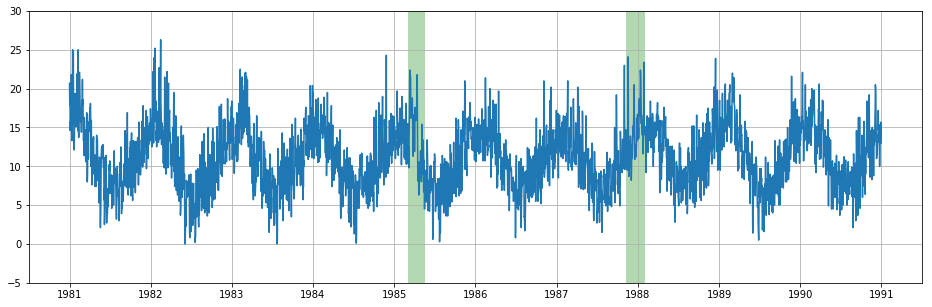

In [34]:
import matplotlib.pyplot as plt
# pandasのデータをplotする際にWarning避けのためにimport
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# jupyter notebook上で図を表示するために挿入
%matplotlib inline

# 値のtypeをintからfloatに変更する．
data = data.astype(float)

# 図示する
plt.figure(figsize=(16,5))
plt.grid()
plt.ylim(-5,30)

# 異常部分を色付けする
data_a1 = data.iloc[1520:1600] # 異常部分1つ目
data_a2 = data.iloc[2500:2590] # 異常部分2つ目

plt.fill_between(data_a1.index, [30]*len(data_a1), [-5]*len(data_a1), facecolor='g', alpha=.3)
plt.fill_between(data_a2.index, [30]*len(data_a2), [-5]*len(data_a2), facecolor='g', alpha=.3)

plt.plot(data)
plt.show();

本実験では気温が急激に上昇したり下降したりしている部分を異常であると考え，2つの異常区間を定めました．

# $k$近傍法による異常検知
**$k$近傍法(k-Nearest Neighbor algorithm)** とは，近傍$k$個のデータからクラスなどの識別を行う方法です．例えば$k=3$とすると，クラスが未知のデータの近くの3つのデータを参考にします(近さはユークリッド距離を用いるのが一般的です)．その3つのデータがどのクラスに属しているかで多数決を行い，多いクラスに未知のデータを分類するというシンプルな考え方です．得票数が同じ($k=4$などのとき，近辺のデータが2つずつそれぞれのクラスに属してる場合)ときはrejectするか，あるいはランダムに振り分けることをします．

では，この$k$近傍法を用いて異常検知を行う考え方について説明します．まず，正常データの集合$\mathcal{D} = \{\boldsymbol{x}_1,\ldots,\boldsymbol{x}_n\}, \ \boldsymbol{x}_i \in \mathbb{R}^N$が与えられているとします．この状況下で未知のデータ$\boldsymbol{x}_{n+1}$が入力されたとき，このデータが集合$\mathcal{D}$のいずれかのデータの近くに存在するのであれば正常だと判断でき，そうでないのなら異常であるというように考えることができます．

これらを時系列データに適用するにあたり，時系列データをベクトル集合にする必要があります．そのために，**Slide window** という技法を用います．時系列データが$x_1,x_2,\ldots$のように与えられているとき，**窓幅**を例えば3と設定したとき，

$$
\begin{align*}
\boldsymbol{x}_1 &= (x_1, x_2, x_3) \\
\boldsymbol{x}_2 &= (x_2, x_3, x_4) \\
\boldsymbol{x}_3 &= (x_3, x_4, x_5) \\
&\quad\vdots
\end{align*}
$$

といった形でベクトルを作成します．

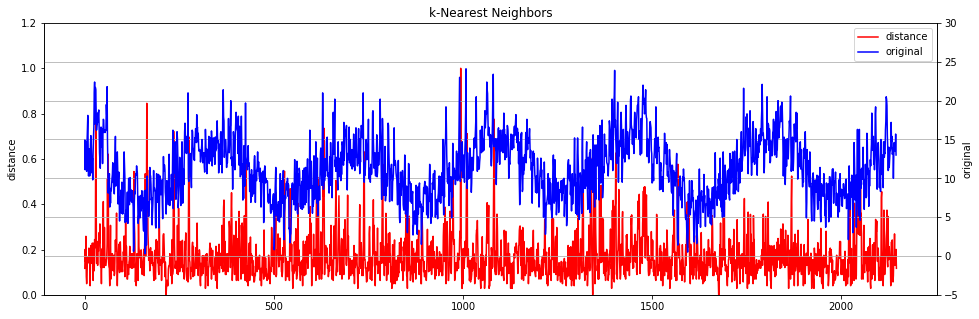

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors


def data_val(data, train_size):
    data = data.astype(float)
    data = data.values
    train_data = data[0:train_size]
    test_data = data[train_size+1:len(data)]
    
    return train_data, test_data


def embed(lst, dim):
    emb = np.empty((0,dim), float)
    for i in range(lst.size - dim + 1):
        tmp = np.array(lst[i:i+dim])[::-1].reshape((1,-1)) 
        emb = np.append( emb, tmp, axis=0)
    
    return emb


def main():
    train_size = 1500
    train_data, test_data = data_val(data, train_size)
    
    # 窓幅を決定する
    width = 3
    # kの値を決定する
    nk = 1

    train = embed(train_data, width)
    test = embed(test_data, width)

    neigh = NearestNeighbors(n_neighbors=nk)
    neigh.fit(train)
    d = neigh.kneighbors(test)[0]

    # 距離をmax1にするデータ整形
    mx = np.max(d)
    d = d / mx

    # 図示する
    test_for_plot = data[train_size+1+width:len(data)].values
    fig = plt.figure(figsize=(16,5))
    ax1 = fig.add_subplot(111)
    ax2 = ax1.twinx()

    p1, = ax1.plot(d, '-r')
    ax1.set_ylabel('distance')
    ax1.set_ylim(0, 1.2)
    p2, = ax2.plot(test_for_plot, '-b')
    ax2.set_ylabel('original')
    ax2.set_ylim(-5, 30)
    plt.title("k-Nearest Neighbors")
    plt.grid()
    ax1.legend([p1, p2], ["distance", "original"])
    # plt.savefig('./result_knn/knn.png')
    plt.show()

if __name__ == '__main__':
    main()

青線が異常の度合い(本実験では距離)となっています．今回は異常と定義した区間が2つのみなので特に閾値の設定などは行っておりません．ある程度異常部分をうまく検知できていますが，誤検知が少し目立ちます．

# ARモデルなどを用いた異常検知
ARなどを用いて予測モデルを構築します．予測モデルによって生成された予測値と実測値の差を正規分布にフィッティングし，**マハラノビス汎距離(Mahalanobis distance)**

$$
a(\boldsymbol{x}) = (\boldsymbol{x} - \boldsymbol{\mu}) \Sigma^{-1} (\boldsymbol{x} - \boldsymbol{\mu})^{\mathrm{T}}
$$

を計算し，それを異常度であると定義します．

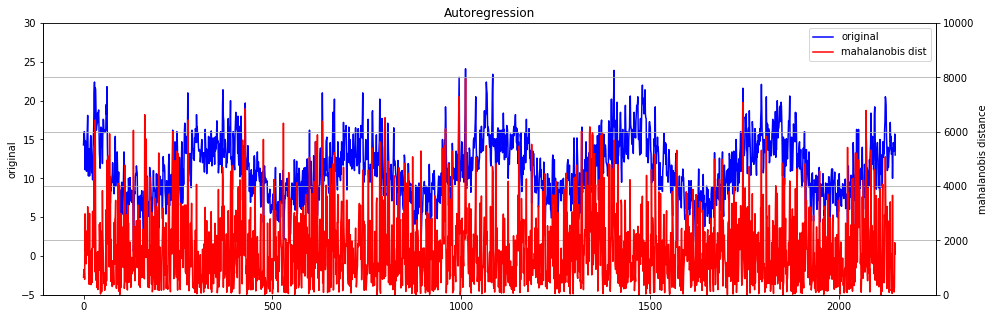

In [40]:
from statsmodels.tsa.ar_model import AR
import numpy as np


def data_val(data, train_size):
    data = data.astype(float)
    data = data.values
    train_data = data[0:train_size]
    test_data = data[train_size+1:len(data)]
    
    return train_data, test_data


def auto_regression(train_data, test_data):
    # 訓練データを用いて予測モデルを作成する
    model = AR(train_data)
    model_fit = model.fit()
    window = model_fit.k_ar
    coef = model_fit.params
    
    # 予測を行う
    hist = train_data[len(train_data) - window:]
    hist = [i for i in hist]
    
    pred = []
    for index, test in enumerate(test_data):
        length = len(hist)
        lag = [hist[i] for i in range(length - window, length)]
        y_ = coef[0]
        for d in range(window):
            y_ += coef[d+1] * lag[window - d - 1]
        obs = test
        pred.append(y_)
        hist.append(obs)
        
    return pred


def compute_error(test_data, pred):
    error = test_data - pred
    mean = sum(error) / len(error)
    
    std = np.std(error-mean)
    std /= len(error)
    
    return error, mean, std


def mahalanobis(x, mean, std):
    d = np.abs(x-mean) / std
    
    return d


def main():
    train_size = 1500
    train_data, test_data = data_val(data, train_size)
    
    pred = auto_regression(train_data, test_data)
    
    # 異常度の計算のため，マハラノビス汎距離の計算をする
    error, mean, std = compute_error(test_data, pred)
    m_dis = []
    for e in error:
        m_dis.append(mahalanobis(e, mean, std))
    
    # 図示する
    fig = plt.figure(figsize=(16,5))
    ax1 = fig.add_subplot(111)
    ax2 = ax1.twinx()

    p1, = ax1.plot(test_data, '-b')
    ax1.set_ylabel('original')
    ax1.set_ylim(-5, 30)
    p2, = ax2.plot(m_dis, '-r')
    ax2.set_ylabel('mahalanobis distance')
    ax2.set_ylim(0, 10000)
    plt.title("Autoregression")
    plt.grid()
    ax1.legend([p1, p2], ["original", "mahalanobis dist"])
    plt.savefig('./result_ar/ar.png')
    plt.show()
    
if __name__ == '__main__':
    main()

本実験ではどの部分でもマハラノビス汎距離が大きくなってしまい，検出するのが難しい状況となっています．閾値をうまく定めれば異常・正常を分けることができそうですが，それでも誤検知が多くなってしまいそうな感じです．

# 特異スペクトル変換を用いた異常検知
**特異スペクトル変換(SSA:Singlar Spectrum Analysis)** とは，時系列データからなんらかの**時系列の特徴** を表す成分を取り出し，成分同士の比較を行い，どの程度の差異が存在するかを異常度合とする手法です．

今，ある時系列データ$x_1,x_2,\ldots,x_T$が存在するとします．これに対し，適当な時間$t$から長さ$w$の成分を抽出し，列ベクトルと見立てます（前述のSlide window）．その操作を$N-1$回繰り返し，順番に並べた行列

$$
\begin{align*}
\mathbf{H}_t =
\left(
\begin{array}{cccc}
    x_t       & x_{t+1}   & \cdots & x_{t+N-1}     \\
    x_{t+1}   & x_{t+2}   & \cdots & x_{t+N}       \\
    \vdots    & \vdots    &        & \vdots        \\
    x_{t+w-1} & x_{t+w}   & \cdots & x_{t+N-1+w-1} \\
\end{array}
\right) \in \mathbb{R}^{w \times N}
\end{align*}
$$

を作成します．この行列は一般的にハンケル行列(Hankel matrix)と呼ばれています．この行列に対し，**特異値分解(SVD:Singular Value Decomposition)** という操作を行います．この操作のことを一般的に特異スペクトル変換といいます．

特異スペクトル変換による異常検知の方法について記述します．

1.ある時間$t$における行列$\mathbf{H}_t$(これを**テスト行列**と呼びます)と，ある時間$L$遡った時間$t-L$地点における行列$\mathbf{H}_{t-L}$(これを**履歴行列**と呼びます)を構成します．

2.1.で作成したテスト行列と履歴行列に対して特異値分解を行い，左特異ベクトルを並べた行列$\mathbf{Q},\mathbf{U}$を求めます．

3.2つの特異ベクトルの組から時系列データのある2か所の変化の仕方の度合，つまり本実験における異常度を

$$
a(t) = 1 - |\mathbf{U}^{\mathrm{T}}\mathbf{Q}|
$$

と定義し，計算します．

4.行列を作成する箇所をスライドさせていくことで，異常度の時系列データを作成します．

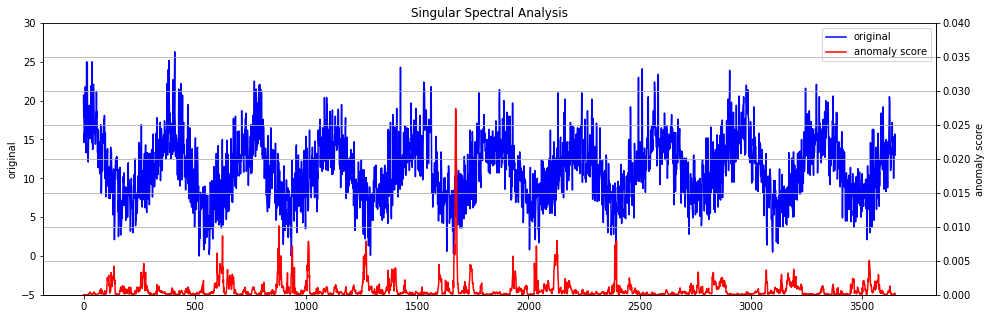

In [113]:
import numpy as np
import pandas as pd


def data_val(data, train_size):
    data = data.astype(float)
    data = data.values
    train_data = data[0:train_size]
    test_data = data[train_size+1:len(data)]
    
    return train_data, test_data


def make_matrix(data, start, end, width):
    """
    Parameters
    ----------
    data  : array-like. 異常検知したい時系列データ
    start : int. 時系列データからベクトルを作るときの始点
    end   : int. 時系列データからベクトルを作るときの終点
    width : int. 時系列データからベクトルを切り出すときの幅
    
    Returns
    -------
    matrix : numpy array. 生成された行列
    
    """
    
    row = width
    column = end - start + 1
    
    matrix = np.empty((row, column))
    i = 0
    for t in range(start, end+1):
        matrix[:, i] = data[t-1:t-1+row]
        i += 1
        
    return matrix


def ssa_ad(data, width, m, k=None, L=None):
    """
    Parameters
    ----------
    data  : array-like. 異常検知したい時系列データ
    width : int. 時系列データからベクトルを切り出すときの幅
    m     : int. 基底ベクトルの本数
    k     : int. 履歴行列とテスト行列の列数
    L     : int. 履歴行列とテスト行列の時間のズレ
    
    Returns
    -------
    ad_score : numpy array. 異常度
    
    """
    
    if type(data) != np.ndarray:
        data = np.array(data)
    if k is None:
        k = width // 2
    if L is None:
        L = k // 2
        
    start_cal = k + width
    end_cal = len(data) - L + 1
    
    ad_score = np.zeros(len(data))
    for t in range(start_cal, end_cal+1):
        # 履歴行列を作る
        s_traj = t - width - k + 1
        e_traj = t - width
        traj_matrix = make_matrix(data, s_traj, e_traj, width)
        
        # テスト行列を作る
        s_test = s_traj + L
        e_test = e_traj + L
        test_matrix = make_matrix(data, s_test, e_test, width)
        
        # 両行列に対して特異値分解を行う
        U_traj, _, _ = np.linalg.svd(traj_matrix, full_matrices=False)
        U_test, _, _ = np.linalg.svd(test_matrix, full_matrices=False)
        U_traj_bv = U_traj[:, :m]
        U_test_bv = U_test[:, :m]
        s = np.linalg.svd(np.dot(U_traj_bv.T, U_test_bv), full_matrices=False, compute_uv=False)
        ad_score[t] = 1 - s[0]
        
    return ad_score


def main():
    # データを読み込む
    data = pd.read_csv('daily-min-temperatures.txt')

    # 1列目の日付をインデックスとして扱うための処理
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)
    data = data.astype(float)
    data = data.values.reshape((len(data)))
    
    
    width = 15
    ad_score = ssa_ad(data, width, 3)

    # 図示する
    fig = plt.figure(figsize=(16,5))
    ax1 = fig.add_subplot(111)
    ax2 = ax1.twinx()

    p1, = ax1.plot(data, '-b')
    ax1.set_ylabel('original')
    ax1.set_ylim(-5, 30)
    p2, = ax2.plot(ad_score, '-r')
    ax2.set_ylabel('anomaly score')
    ax2.set_ylim(0, 0.04)
    plt.title("Singular Spectral Analysis")
    plt.grid()
    ax1.legend([p1, p2], ["original", "anomaly score"])
    plt.savefig('./result_ssa/ssa.png')
    plt.show()
    
    
if __name__ == '__main__':
    main()

異常と定めた部分とは違う部分で大きく異常度が出てしまっているため，うまく検知できていないようです．窓幅や基底ベクトルの本数を調整することで変わる可能性もありますが，基底ベクトルの本数は増やしすぎると異常度が検出されなくなってしまいま